In [1]:
# ============================
#  Title:  Multi-Classifier Modeling, Hyperparameter Tuning & Evaluation
#  Author: [Your Name or Team]
#  Date:   [Date]
#  Notes:  This script showcases a comprehensive pipeline for loading data,
#          preprocessing, model training, hyperparameter tuning, and evaluation
#          across multiple algorithms: RandomForest, GradientBoosting,
#          HistGradientBoosting, XGBoost, and CatBoost. Includes interpretability
#          with SHAP, partial dependence plots, and feature importances.
# ============================

# Setting Up

In [216]:
# ================
# 1. IMPORTS
# ================
import os
import logging
import warnings
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

from sklearn.model_selection import (
    train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, RandomizedSearchCV, RepeatedStratifiedKFold
)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, 
    HistGradientBoostingClassifier
)
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Interpretability
import shap
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

# Optimization
import optuna

In [217]:
# ================
# 2. CONFIGURATION
# ================
RANDOM_STATE = 42
TEST_SIZE = 0.2
N_SPLITS_CV = 5
SCORING_METRIC = 'roc_auc'
VERBOSE = 1

CPU_COUNT = os.cpu_count()

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [218]:
# ================
# 3. HELPER FUNCTIONS
# ================

def load_data(filepath: str) -> pd.DataFrame:
    """
    Loads data from a CSV file into a Pandas DataFrame.
    
    Parameters
    ----------
    filepath : str
        Full path to the CSV file.
    
    Returns
    -------
    pd.DataFrame or None
        Loaded DataFrame if successful, None if file not found.
    """
    try:
        df = pd.read_csv(os.path.expanduser(filepath))
        logging.info("Data loaded successfully.")
        return df
    except FileNotFoundError:
        logging.error(f"File not found at {filepath}")
        return None


def identify_categorical_columns(df: pd.DataFrame) -> list:
    """
    Identifies columns of type object or category in a DataFrame.
    """
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    logging.info(f"Identified categorical columns: {categorical_cols}")
    return categorical_cols


def convert_to_categorical(df: pd.DataFrame, columns: list) -> None:
    """
    Converts specified columns in a DataFrame to categorical type in-place.
    """
    for col in columns:
        if col in df.columns:
            df[col] = df[col].astype('category')
        else:
            logging.warning(f"Column '{col}' not found in DataFrame.")
    logging.info("Categorical conversion complete.")


def create_train_test_split(
    X: pd.DataFrame, 
    y: pd.Series, 
    test_size: float = TEST_SIZE, 
    random_state: int = RANDOM_STATE
) -> tuple:
    """
    Splits data into training and testing sets.
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, 
        stratify=y, shuffle=True
    )
    logging.info(f"Training set shape: {X_train.shape}")
    logging.info(f"Testing set shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test


def create_missing_indicators(
    X_train: pd.DataFrame, 
    X_test: pd.DataFrame
) -> tuple:
    """
    Creates binary indicators for missing values in features.
    """
    missing_indicator = MissingIndicator(features='all')
    missing_indicator.fit(X_train)
    X_train_flags = missing_indicator.transform(X_train)
    X_test_flags = missing_indicator.transform(X_test)
    
    missing_columns = [f'missing_{col}' for col in X_train.columns]
    X_train_with_indicators = pd.concat(
        [X_train.reset_index(drop=True),
         pd.DataFrame(X_train_flags, columns=missing_columns)],
        axis=1
    )
    X_test_with_indicators = pd.concat(
        [X_test.reset_index(drop=True),
         pd.DataFrame(X_test_flags, columns=missing_columns)],
        axis=1
    )
    logging.info("Missing indicators created.")
    return X_train_with_indicators, X_test_with_indicators


def create_preprocessor(categorical_features: list) -> ColumnTransformer:
    """
    Creates a preprocessor for categorical features using OneHotEncoder
    while passing other columns through without transformation.
    """
    preprocessor = ColumnTransformer(
        transformers=[
            (
                'cat', 
                OneHotEncoder(
                    drop='first', 
                    handle_unknown='ignore', 
                    sparse_output=False
                ),
                categorical_features
            )
        ],
        remainder='passthrough'
    )
    return preprocessor


def train_evaluate_model(
    model, 
    X_train: pd.DataFrame, 
    y_train: pd.Series, 
    X_test: pd.DataFrame, 
    y_test: pd.Series, 
    model_name: str = "Model", 
    save_path: str = None
):
    """
    Trains, evaluates, and optionally saves a model. 
    Prints confusion matrix, classification report, and ROC AUC.
    Plots the ROC curve.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    logging.info(f"=== {model_name} Evaluation ===")
    logging.info("Confusion Matrix:\n" + str(confusion_matrix(y_test, y_pred)))
    logging.info("\nClassification Report:\n" + str(classification_report(y_test, y_pred)))
    logging.info(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_pred_proba):.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve on Test Data')
    plt.legend(loc='lower right')
    plt.show()
    
    if save_path:
        joblib.dump(model, save_path)
        logging.info(f"{model_name} saved to '{save_path}'.")
    
    return model


def perform_grid_search(
    pipeline: Pipeline, 
    param_grid: dict, 
    X_train: pd.DataFrame, 
    y_train: pd.Series, 
    cv=None, 
    scoring: str = 'roc_auc', 
    n_jobs: int = -1, 
    verbose: int = 1
):
    """
    Performs GridSearchCV for hyperparameter tuning on a pipeline.
    """
    if cv is None:
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(
        estimator=pipeline, 
        param_grid=param_grid, 
        cv=cv, 
        scoring=scoring, 
        n_jobs=n_jobs, 
        verbose=verbose
    )
    grid_search.fit(X_train, y_train)
    logging.info("Best parameters found: " + str(grid_search.best_params_))
    logging.info(f"Best cross-validation {scoring}: {grid_search.best_score_:.4f}")
    return grid_search.best_estimator_


def plot_feature_importance(
    model, 
    feature_names: list, 
    top_n: int = 20, 
    title: str = "Feature Importance"
):
    """
    Plots the top N feature importances from a trained model.
    """
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'named_steps') and 'classifier' in model.named_steps:
        if hasattr(model.named_steps['classifier'], 'feature_importances_'):
            importances = model.named_steps['classifier'].feature_importances_
        else:
            raise ValueError("Classifier does not have feature_importances_ attribute.")
    else:
        raise ValueError("Provided model does not have feature_importances_ attribute.")
    
    fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    fi_df = fi_df.sort_values('Importance', ascending=False).head(top_n)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=fi_df)
    plt.title(title)
    plt.tight_layout()
    plt.show()


def aggregate_feature_importance(importances: np.ndarray, encoded_feature_names: list) -> pd.DataFrame:
    """
    Aggregates feature importance of one-hot-encoded features back to original feature names.
    """
    original_features = list(set([feat.split('_')[0] for feat in encoded_feature_names]))
    original_feature_importance = {feature: 0 for feature in original_features}
    for i, encoded_feature in enumerate(encoded_feature_names):
        base_feature = encoded_feature.split('_')[0]
        original_feature_importance[base_feature] += importances[i]
    
    importance_df = pd.DataFrame(
        list(original_feature_importance.items()), 
        columns=['Feature', 'Importance']
    )
    importance_df = importance_df.sort_values('Importance', ascending=False)
    return importance_df


def plot_aggregated_feature_importance(
    importance_df: pd.DataFrame, 
    top_n: int = 20, 
    title: str = "Aggregated Feature Importance"
):
    """
    Plots aggregated feature importances after grouping by base feature.
    """
    top_n_df = importance_df.head(top_n).sort_values(by='Importance', ascending=True)
    plt.figure(figsize=(10, 6))
    plt.barh(y=top_n_df['Feature'], width=top_n_df['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Preprocessing

In [219]:
# --- Data Loading ---
data_filepath = os.path.expanduser('~/work/vaping_project_data/processed_data_g12.csv')
new_data = load_data(data_filepath)
if new_data is None:
    logging.error("Data loading failed. Exiting script.")
    raise SystemExit

logging.info("Dataset Info:")
new_data.info()

# --- Identify & Convert Categorical Columns ---
categorical_cols_initial = identify_categorical_columns(new_data)

# Define columns to treat as categorical
categorical_predictor_cols = [
    'V13', 'RESPONDENT_AGE', 'V2152', 'V2153', 'V49', 'V2155', 'V2156', 'V2157',
    'V2163', 'V2164', 'V2166', 'V2169', 'V2171', 'V2172', 'V2173', 'V2175', 'V2176',
    'V2177', 'V2178', 'V2179', 'V2180', 'V2182', 'V2183', 'V2184', 'V2185', 'V2187',
    'V2188', 'V2189', 'V2181', 'V2186', 'V2191', 'V2193', 'V2194', 'V2195', 'V2196',
    'V2197', 'V2201', 'V2101', 'V2105', 'V2108', 'V2116', 'V2119', 'V2122', 'V2033',
    'V2125', 'V2460', 'V2128', 'V2030', 'V2134', 'V2137', 'V2140', 'V2143', 'V2907',
    'V2908', 'V2146', 'V2494', 'wave', 'sex', 'race', 'nicotine12d'
]
convert_to_categorical(new_data, categorical_predictor_cols)

logging.info("Verifying data types after conversion:")
logging.info(new_data[categorical_predictor_cols].dtypes)

# Drop rows with missing target column 'nicotine12d'
new_data_nona = new_data.dropna(subset=['nicotine12d'])
if new_data_nona.empty:
    logging.error("No data remaining after dropping rows with missing target values. Exiting script.")
    raise SystemExit

# --- Train/Test Split ---
X = new_data_nona.drop('nicotine12d', axis=1)
y = new_data_nona['nicotine12d']
X_train, X_test, y_train, y_test = create_train_test_split(X, y)

logging.info("Train Set Balance:")
logging.info(y_train.value_counts(normalize=True))
logging.info("Test Set Balance:")
logging.info(y_test.value_counts(normalize=True))

# --- Missing Value Indicators ---
X_train_with_indicators, X_test_with_indicators = create_missing_indicators(X_train, X_test)

# Treat everything as categorical in this example
categorical_features = X_train_with_indicators.columns.tolist()

# Create & Fit Preprocessor
preprocessor = create_preprocessor(categorical_features)
preprocessor.fit(X_train_with_indicators)
logging.info("Preprocessor fitted successfully.")

2025-01-22 17:57:47,553 - INFO - Data loaded successfully.
2025-01-22 17:57:47,554 - INFO - Dataset Info:
2025-01-22 17:57:47,581 - INFO - Identified categorical columns: []


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64128 entries, 0 to 64127
Data columns (total 60 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   V13             64128 non-null  int64  
 1   RESPONDENT_AGE  60018 non-null  float64
 2   V2152           62158 non-null  float64
 3   V2153           59253 non-null  float64
 4   V49             59655 non-null  float64
 5   V2155           59583 non-null  float64
 6   V2156           59583 non-null  float64
 7   V2157           59583 non-null  float64
 8   V2163           59497 non-null  float64
 9   V2164           59475 non-null  float64
 10  V2166           58075 non-null  float64
 11  V2169           47001 non-null  float64
 12  V2171           59041 non-null  float64
 13  V2172           58643 non-null  float64
 14  V2173           58443 non-null  float64
 15  V2175           57248 non-null  float64
 16  V2176           56183 non-null  float64
 17  V2177           56909 non-null 

2025-01-22 17:57:47,859 - INFO - Categorical conversion complete.
2025-01-22 17:57:47,859 - INFO - Verifying data types after conversion:
2025-01-22 17:57:47,862 - INFO - V13               category
RESPONDENT_AGE    category
V2152             category
V2153             category
V49               category
V2155             category
V2156             category
V2157             category
V2163             category
V2164             category
V2166             category
V2169             category
V2171             category
V2172             category
V2173             category
V2175             category
V2176             category
V2177             category
V2178             category
V2179             category
V2180             category
V2182             category
V2183             category
V2184             category
V2185             category
V2187             category
V2188             category
V2189             category
V2181             category
V2186             category
V2191             c

# Model Training

## Random Forest Classifier

In [ ]:
# Define your Random State for reproducibility
RANDOM_STATE = 42

# Example: Use RepeatedStratifiedKFold for more robust validation
N_SPLITS_CV = 5
N_REPEATS = 1  # repeat the CV multiple times if desired
SCORING_METRIC = 'roc_auc'
VERBOSE = 1

logging.info("\n--- Random Forest (Revised) ---")

# Build your pipeline
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor), 
    ('classifier', RandomForestClassifier(random_state=RANDOM_STATE))
])

# Expanded parameter distributions for RandomizedSearch
rf_param_dist = {
    'classifier__n_estimators': [100, 200, 500, 1000],
    'classifier__max_depth': [5, 10, 20, 50],
    'classifier__min_samples_split': [2, 5, 10, 20],
    'classifier__min_samples_leaf': [1, 2, 5, 10],
    'classifier__max_features': ['sqrt', 'log2', 0.3, 0.5, 0.7],  # Mix of float and string
    'classifier__bootstrap': [True, False],
    'classifier__class_weight': [None, 'balanced']
}

try:
    logging.info("Starting randomized search for Random Forest...")
    
    # Use RepeatedStratifiedKFold without shuffle
    cv_rf = RepeatedStratifiedKFold(
        n_splits=N_SPLITS_CV, 
        n_repeats=N_REPEATS, 
        random_state=RANDOM_STATE
    )
    
    # RandomizedSearchCV to cover more combinations within reasonable compute time
    rf_random_search = RandomizedSearchCV(
        estimator=rf_pipeline,
        param_distributions=rf_param_dist,
        n_iter=30,  # Increase or decrease based on resources
        cv=cv_rf,
        scoring=SCORING_METRIC,
        n_jobs=-1,  # Use all available cores
        random_state=RANDOM_STATE,
        verbose=VERBOSE
    )
    
    # Fit the RandomizedSearchCV
    rf_random_search.fit(X_train_with_indicators, y_train)

    logging.info(f"Best parameters (RF): {rf_random_search.best_params_}")
    logging.info(f"Best cross-validation {SCORING_METRIC}: {rf_random_search.best_score_:.4f}")
    
    # Extract the best estimator
    best_rf = rf_random_search.best_estimator_

except Exception as e:
    logging.error(f"An error occurred during Random Forest randomized search: {e}")
    raise

# Evaluate the best Random Forest
try:
    best_rf.fit(X_train_with_indicators, y_train)
    y_pred_rf = best_rf.predict(X_test_with_indicators)
    y_pred_proba_rf = best_rf.predict_proba(X_test_with_indicators)[:, 1]

    logging.info("=== Best Random Forest Evaluation ===")
    logging.info("Confusion Matrix:\n" + str(confusion_matrix(y_test, y_pred_rf)))
    logging.info("\nClassification Report:\n" + str(classification_report(y_test, y_pred_rf)))
    logging.info(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")

    # Plot ROC
    fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_rf, tpr_rf, label=f'AUC = {roc_auc_score(y_test, y_pred_proba_rf):.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Random Forest ROC Curve on Test Data')
    plt.legend(loc='lower right')
    plt.show()

except Exception as e:
    logging.error(f"An error occurred during Random Forest training/evaluation: {e}")
    raise

logging.info("Script completed successfully.")

In [8]:
# Define the model file path
model_filename = os.path.expanduser('~/work/vaping_project_data/best_rf_model.joblib')

# Save the trained model
joblib.dump(best_rf, model_filename)
logging.info(f"Model saved to {model_filename}")

2025-01-17 23:46:26,623 - INFO - Model saved to /storage/home/szn5432/work/vaping_project_data/best_rf_model.joblib


In [6]:
# Load the model from the specified path
logging.info("Loading the model...")
best_rf = joblib.load(os.path.expanduser('~/work/vaping_project_data/best_rf_model.joblib'))
logging.info("Model loaded successfull")

2025-01-19 07:47:45,407 - INFO - Loading the model...
2025-01-19 07:47:46,493 - INFO - Model loaded successfull


2025-01-19 07:47:48,349 - INFO - Starting feature importance analysis...
2025-01-19 07:47:48,514 - INFO - Shape of X_train_with_indicators: (28196, 118)
2025-01-19 07:47:48,515 - INFO - Length of feature_importance: 378
2025-01-19 07:47:48,515 - INFO - Number of feature names: 378
2025-01-19 07:47:48,517 - INFO - Feature names: ['cat__V13_2' 'cat__V13_3' 'cat__V13_4' 'cat__RESPONDENT_AGE_2.0'
 'cat__RESPONDENT_AGE_nan' 'cat__V2152_1.0' 'cat__V2152_2.0'
 'cat__V2152_3.0' 'cat__V2152_4.0' 'cat__V2152_5.0' 'cat__V2152_6.0'
 'cat__V2152_7.0' 'cat__V2152_8.0' 'cat__V2152_9.0' 'cat__V2152_nan'
 'cat__V2153_2.0' 'cat__V2153_3.0' 'cat__V2153_4.0' 'cat__V2153_nan'
 'cat__V49_1.0' 'cat__V49_2.0' 'cat__V49_3.0' 'cat__V49_nan'
 'cat__V2155_1.0' 'cat__V2155_nan' 'cat__V2156_1.0' 'cat__V2156_nan'
 'cat__V2157_1.0' 'cat__V2157_nan' 'cat__V2163_2.0' 'cat__V2163_3.0'
 'cat__V2163_4.0' 'cat__V2163_5.0' 'cat__V2163_6.0' 'cat__V2163_7.0'
 'cat__V2163_nan' 'cat__V2164_2.0' 'cat__V2164_3.0' 'cat__V2164_4.0'

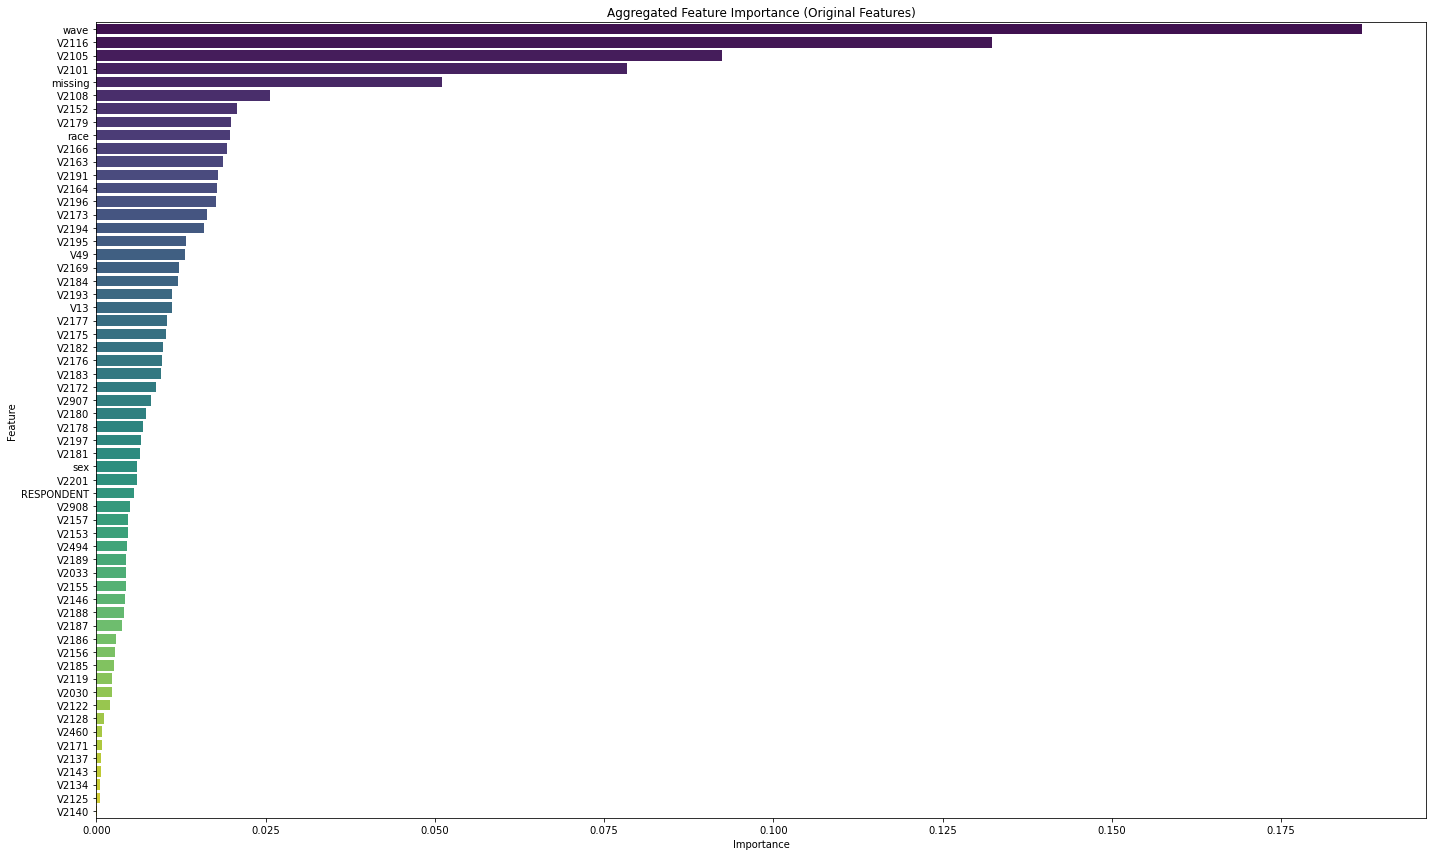

In [7]:
try:
    logging.info("Starting feature importance analysis...")

    # Access the RandomForestClassifier from the pipeline
    rf_model = best_rf.named_steps['classifier']

    # Get feature importances
    feature_importance = rf_model.feature_importances_

    # Access the preprocessor step
    preprocessor = best_rf.named_steps['preprocessor']

    # Get transformed feature names
    if hasattr(preprocessor, 'get_feature_names_out'):
        feature_names = preprocessor.get_feature_names_out()
    else:
        # Fallback: Generate feature names if get_feature_names_out is not available
        X_train_transformed = preprocessor.transform(X_train_with_indicators)
        feature_names = [f"Feature_{idx}" for idx in range(X_train_transformed.shape[1])]

    # Debugging: Print shapes and lengths
    logging.info(f"Shape of X_train_with_indicators: {X_train_with_indicators.shape}")
    logging.info(f"Length of feature_importance: {len(feature_importance)}")
    logging.info(f"Number of feature names: {len(feature_names)}")
    logging.info(f"Feature names: {feature_names}")

    # Check if lengths match
    if len(feature_names) != len(feature_importance):
        raise ValueError(
            f"Mismatch in lengths: feature_names ({len(feature_names)}) != feature_importance ({len(feature_importance)})"
        )

    # Create a DataFrame for visualization
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    })

    # Aggregate importances for original features
    original_feature_importance = {}

    for feature, importance in zip(feature_names, feature_importance):
        # Extract the original feature name (e.g., 'cat__V13_2' -> 'V13')
        original_feature = feature.split('__')[1].split('_')[0]

        # Sum importances for each original feature
        if original_feature in original_feature_importance:
            original_feature_importance[original_feature] += importance
        else:
            original_feature_importance[original_feature] = importance

    # Create a DataFrame for aggregated importances
    aggregated_importance_df = pd.DataFrame({
        'Feature': list(original_feature_importance.keys()),
        'Importance': list(original_feature_importance.values())
    })

    # Sort features by importance
    aggregated_importance_df = aggregated_importance_df.sort_values(by='Importance', ascending=False)

    # Plot aggregated feature importance
    plt.figure(figsize=(20, 12))
    sns.barplot(x='Importance', y='Feature', data=aggregated_importance_df, palette='viridis')
    plt.title('Aggregated Feature Importance (Original Features)')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

except Exception as e:
    logging.error(f"An error occurred during feature importance analysis: {e}")
    raise

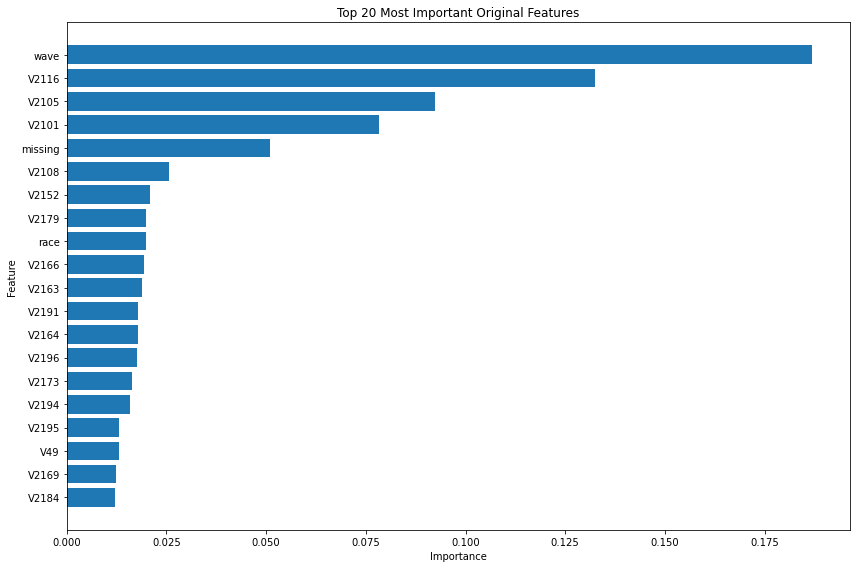


Feature Importance Rankings:
       Feature  Importance
24        wave    0.186994
4        V2116    0.132368
33       V2105    0.092418
37       V2101    0.078361
35     missing    0.051054
19       V2108    0.025626
0        V2152    0.020803
57       V2179    0.019934
55        race    0.019808
32       V2166    0.019341
56       V2163    0.018782
13       V2191    0.017948
8        V2164    0.017778
36       V2196    0.017719
18       V2173    0.016294
49       V2194    0.015857
38       V2195    0.013212
21         V49    0.013146
26       V2169    0.012226
2        V2184    0.012104
14       V2193    0.011222
5          V13    0.011126
12       V2177    0.010443
40       V2175    0.010250
17       V2182    0.009841
11       V2176    0.009708
27       V2183    0.009505
28       V2172    0.008756
25       V2907    0.008110
52       V2180    0.007307
31       V2178    0.006836
3        V2197    0.006604
44       V2181    0.006473
22         sex    0.006043
30       V2201    0.00599

In [29]:
# Get the Gradient Boosting classifier and feature importances
rf_classifier = best_rf.named_steps['classifier']
importances = rf_classifier.feature_importances_

# Fit the preprocessor (if needed)
best_rf.fit(X_train_with_indicators, y_train)

# Get the OneHotEncoder from the pipeline
ohe = best_rf.named_steps['preprocessor'].named_transformers_['cat']

# Get all encoded feature names
encoded_feature_names = ohe.get_feature_names_out()

# Extract original feature names from encoded features
original_features = list(set([feat.split('_')[0] for feat in encoded_feature_names]))

# Create a dictionary to store original feature importances
original_feature_importance = {}

# Sum the importances of all encoded features from this original feature
for feature in original_features:
    encoded_features_mask = [str(name).startswith(feature + '_') for name in encoded_feature_names]
    importance = importances[encoded_features_mask].sum()
    original_feature_importance[feature] = importance

# Convert to DataFrame and sort by ascending order
feature_importance_df = pd.DataFrame({
    'Feature': original_feature_importance.keys(),
    'Importance': original_feature_importance.values()
})
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=True)

# Take top 20 and plot
top_20 = feature_importance_df.tail(20)  # Use tail to get highest values

plt.figure(figsize=(12, 8))
plt.barh(y=top_20['Feature'], width=top_20['Importance'])
plt.title('Top 20 Most Important Original Features')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Print the DataFrame (in descending order for readability)
print("\nFeature Importance Rankings:")
print(feature_importance_df.sort_values('Importance', ascending=False))

In [8]:
# Extract the classifier from the pipeline
tree_model = best_rf.named_steps['classifier']

In [9]:
X_processed = preprocessor.transform(X_train_with_indicators)
# Use a subset of the training data as background
background = shap.sample(X_processed, 5000)  # any reasonable number
explainer = shap.TreeExplainer(tree_model, data=background)

In [10]:
# Sample a subset of rows from X_processed for SHAP computation
subset_size = 1000  # adjust as needed
sample_idx = np.random.choice(X_processed.shape[0], size=subset_size, replace=False)
X_sample = X_processed[sample_idx]

# Compute SHAP values on the smaller subset
shap_values_sample = explainer.shap_values(X_sample)

100%|===================| 1999/2000 [17:47<00:00]        

In [11]:
# Select SHAP values for the positive class (class index 1)
shap_values_class1 = shap_values_sample[:, :, 1]

# Compute mean absolute SHAP values across samples for each feature
mean_abs_shap = np.abs(shap_values_class1).mean(axis=0)  # shape should be (378,)

# Retrieve transformed feature names from the preprocessor
feature_names = preprocessor.get_feature_names_out()

# Verify dimensions match
assert len(feature_names) == mean_abs_shap.shape[0], "Mismatch between feature names and SHAP values length."

In [12]:
# Verify the shape and type of your selected SHAP values for the positive class
print(type(shap_values_class1))
print(shap_values_class1.shape)

<class 'numpy.ndarray'>
(1000, 378)


In [13]:
shap_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Mean_Absolute_SHAP': mean_abs_shap
})

In [14]:
# Aggregate SHAP Importances
# Extract base feature names using regex; adjust pattern if necessary
shap_importance_df['Base_Feature'] = shap_importance_df['Feature'].str.extract(
    r'^(.*?)_\d+\.?\d*$|^(.*?)_nan$|^(.*?)_True$'
).bfill(axis=1).iloc[:, 0]

aggregated_shap_importance = (
    shap_importance_df.groupby('Base_Feature', sort=False)['Mean_Absolute_SHAP']
    .sum()
    .reset_index()
)

aggregated_shap_importance = aggregated_shap_importance.sort_values(
    by='Mean_Absolute_SHAP', ascending=False
)

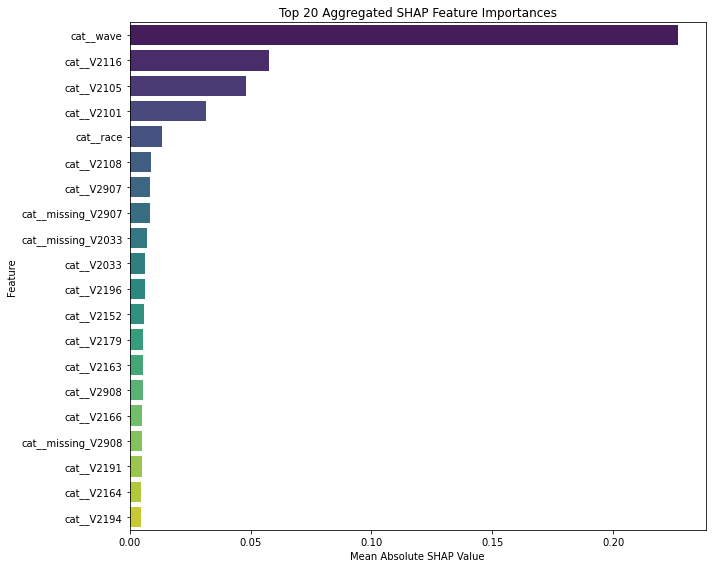

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

top_n = 20
top_features_df = aggregated_shap_importance.head(top_n)

plt.figure(figsize=(10, 8))
sns.barplot(x='Mean_Absolute_SHAP', y='Base_Feature', data=top_features_df, palette='viridis')
plt.title(f'Top {top_n} Aggregated SHAP Feature Importances')
plt.xlabel('Mean Absolute SHAP Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [20]:
# Suppress warnings about unknown categories in the encoder
warnings.filterwarnings(
    "ignore",
    message="Found unknown categories in columns",
    category=UserWarning,
    module="sklearn.preprocessing._encoders"
)

<Figure size 864x576 with 0 Axes>

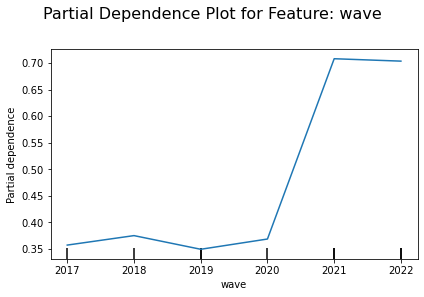

<Figure size 864x576 with 0 Axes>

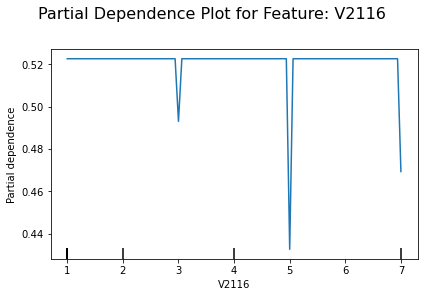

<Figure size 864x576 with 0 Axes>

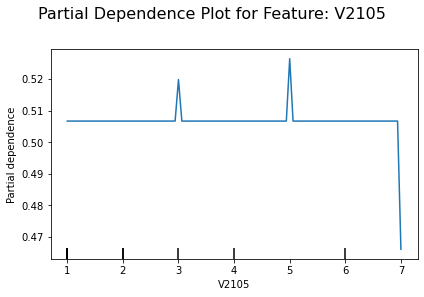

<Figure size 864x576 with 0 Axes>

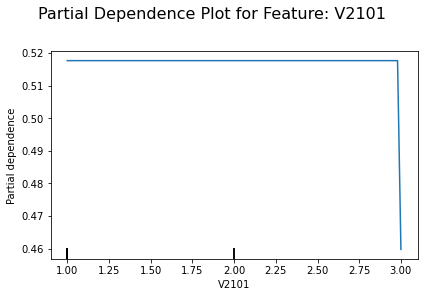

/storage/home/szn5432/.local/lib/python3.9/site-packages/sklearn/inspection/_plot/partial_dependence.py:976: UserWarning: Attempting to set identical bottom == top == 0.5170027944103662 results in singular transformations; automatically expanding.
  ax.set_ylim([min_val, max_val])


<Figure size 864x576 with 0 Axes>

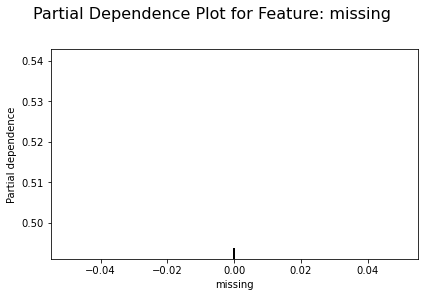

<Figure size 864x576 with 0 Axes>

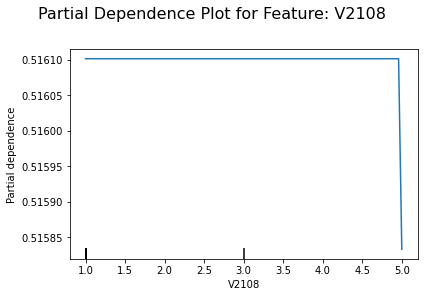

<Figure size 864x576 with 0 Axes>

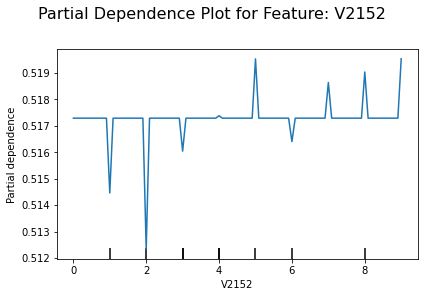

<Figure size 864x576 with 0 Axes>

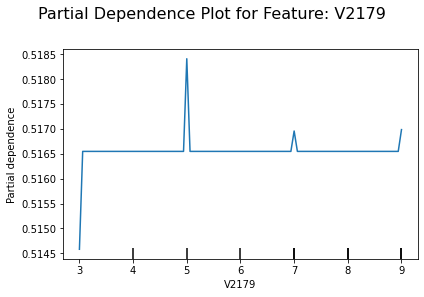

/storage/home/szn5432/.local/lib/python3.9/site-packages/sklearn/inspection/_plot/partial_dependence.py:976: UserWarning: Attempting to set identical bottom == top == 0.5105686199552415 results in singular transformations; automatically expanding.
  ax.set_ylim([min_val, max_val])


<Figure size 864x576 with 0 Axes>

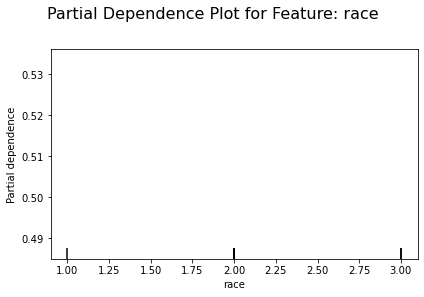

<Figure size 864x576 with 0 Axes>

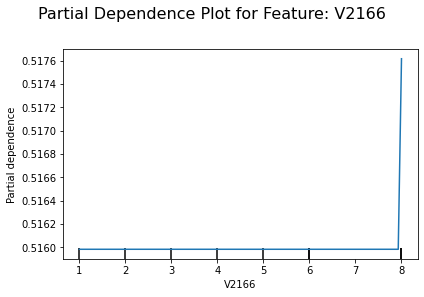

In [21]:
# PDP Plot

# Get the indices of top 10 features
top_10_indices = aggregated_importance_df.index[:10].tolist()
feature_names = aggregated_importance_df['Feature'].to_dict()

# Loop through each feature and create individual PDP plots
for idx in top_10_indices:
    # Create a new figure for each plot with large size
    plt.figure(figsize=(12, 8))
    
    # Create single PDP plot
    pdp = PartialDependenceDisplay.from_estimator(
        best_rf, 
        X_train_with_indicators, 
        features=[idx],  # Pass the feature index directly for PDP
        feature_names=feature_names,
        random_state=42
    )
    
    # Add title for each plot
    plt.suptitle(f'Partial Dependence Plot for Feature: {feature_names[idx]}', 
                 fontsize=16, 
                 y=1.02)
    
    # Adjust layout
    plt.tight_layout()
    
    # Show each plot
    plt.show()

## Gradient Boosting Trees

2025-01-19 15:09:55,891 - INFO - 
--- Gradient Boosting (Revised) ---
2025-01-19 15:09:55,892 - INFO - Starting randomized search for Gradient Boosting...


Fitting 5 folds for each of 30 candidates, totalling 150 fits


/storage/home/szn5432/.local/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [47] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/storage/home/szn5432/.local/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [50] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/storage/home/szn5432/.local/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [50] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/storage/home/szn5432/.local/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [50] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/storage/home/szn5432/.local/lib/python3

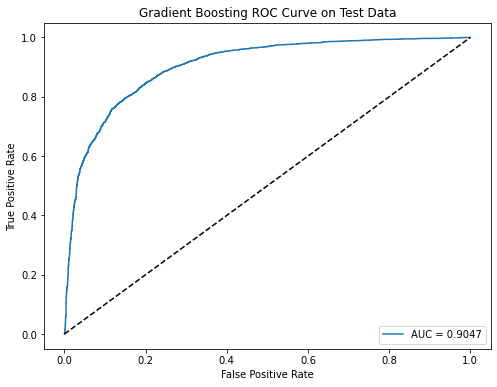

2025-01-19 15:21:32,012 - INFO - Script completed successfully.


In [22]:
import logging
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Random State for reproducibility
RANDOM_STATE = 42

# Use RepeatedStratifiedKFold for more robust validation
N_SPLITS_CV = 5
N_REPEATS = 1  # Repeat the CV multiple times if desired
SCORING_METRIC = 'roc_auc'
VERBOSE = 1

logging.info("\n--- Gradient Boosting (Revised) ---")

# Build pipeline
gbc_pipeline = Pipeline([
    ('preprocessor', preprocessor), 
    ('classifier', GradientBoostingClassifier(random_state=RANDOM_STATE))
])

# Expanded parameter distributions for RandomizedSearch
gbc_param_dist = {
    'classifier__n_estimators': [100, 300, 500, 1000],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 10, 20],
    'classifier__subsample': [0.8, 0.9, 1.0],  # Controls sample ratio per tree
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 5],
    'classifier__max_features': ['sqrt', 'log2', None]
}

try:
    logging.info("Starting randomized search for Gradient Boosting...")

    # Use RepeatedStratifiedKFold without shuffle
    cv_gbc = RepeatedStratifiedKFold(
        n_splits=N_SPLITS_CV, 
        n_repeats=N_REPEATS, 
        random_state=RANDOM_STATE
    )

    # RandomizedSearchCV to cover more combinations within reasonable compute time
    gbc_random_search = RandomizedSearchCV(
        estimator=gbc_pipeline,
        param_distributions=gbc_param_dist,
        n_iter=30,  # Increase or decrease based on resources
        cv=cv_gbc,
        scoring=SCORING_METRIC,
        n_jobs=24,  # Use all available cores
        random_state=RANDOM_STATE,
        verbose=VERBOSE
    )

    # Fit the RandomizedSearchCV
    gbc_random_search.fit(X_train_with_indicators, y_train)

    logging.info(f"Best parameters (GBC): {gbc_random_search.best_params_}")
    logging.info(f"Best cross-validation {SCORING_METRIC}: {gbc_random_search.best_score_:.4f}")

    # Extract the best estimator
    best_gbc = gbc_random_search.best_estimator_

except Exception as e:
    logging.error(f"An error occurred during Gradient Boosting randomized search: {e}")
    raise

# Evaluate the best Gradient Boosting model
try:
    best_gbc.fit(X_train_with_indicators, y_train)
    y_pred_gbc = best_gbc.predict(X_test_with_indicators)
    y_pred_proba_gbc = best_gbc.predict_proba(X_test_with_indicators)[:, 1]

    logging.info("=== Best Gradient Boosting Evaluation ===")
    logging.info("Confusion Matrix:\n" + str(confusion_matrix(y_test, y_pred_gbc)))
    logging.info("\nClassification Report:\n" + str(classification_report(y_test, y_pred_gbc)))
    logging.info(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_gbc):.4f}")

    # Plot ROC Curve
    fpr_gbc, tpr_gbc, _ = roc_curve(y_test, y_pred_proba_gbc)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_gbc, tpr_gbc, label=f'AUC = {roc_auc_score(y_test, y_pred_proba_gbc):.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Gradient Boosting ROC Curve on Test Data')
    plt.legend(loc='lower right')
    plt.show()

except Exception as e:
    logging.error(f"An error occurred during Gradient Boosting training/evaluation: {e}")
    raise

logging.info("Script completed successfully.")

In [23]:
# Define the model file path
model_filename = os.path.expanduser('~/work/vaping_project_data/best_gbt_model.joblib')

# Save the trained model
joblib.dump(best_gbc, model_filename)
logging.info(f"Model saved to {model_filename}")

2025-01-19 15:23:19,394 - INFO - Model saved to /storage/home/szn5432/work/vaping_project_data/best_gbt_model.joblib


In [8]:
# Load the model (when needed)
file_path = os.path.expanduser('~/work/vaping_project_data/best_gbt_model.joblib')
loaded_gbt = joblib.load(file_path)
print("Model loaded successfully.")

Model loaded successfully.


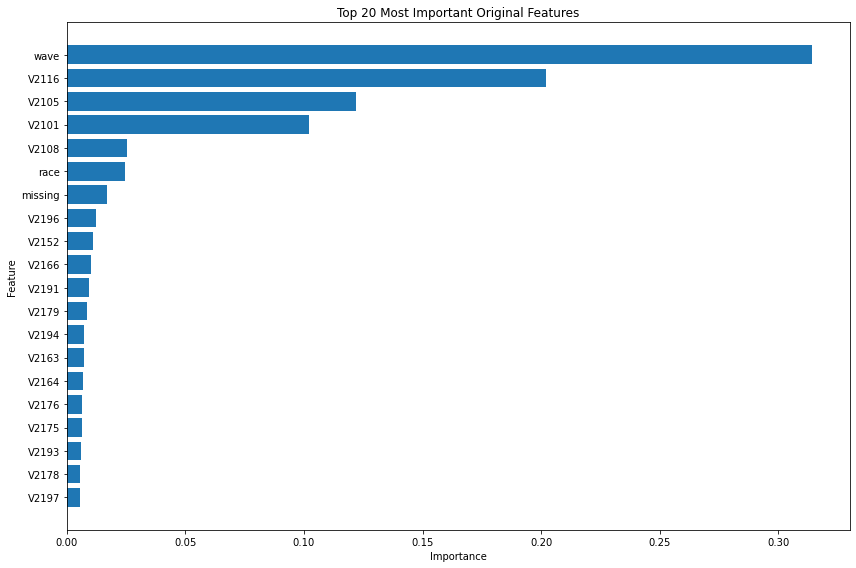


Feature Importance Rankings:
       Feature  Importance
30        wave    0.314373
5        V2116    0.202225
4        V2105    0.121904
19       V2101    0.102134
21       V2108    0.025576
8         race    0.024710
31     missing    0.016738
0        V2196    0.012104
12       V2152    0.011231
25       V2166    0.010183
29       V2191    0.009159
44       V2179    0.008551
1        V2194    0.007245
3        V2163    0.007134
39       V2164    0.006955
53       V2176    0.006525
7        V2175    0.006251
32       V2193    0.006178
49       V2178    0.005596
54       V2197    0.005587
47       V2173    0.005427
11       V2177    0.005360
34       V2195    0.005263
22         V13    0.005032
28         V49    0.004572
41       V2201    0.004482
14       V2169    0.003695
38       V2184    0.003689
40       V2183    0.003665
27       V2172    0.003422
10       V2182    0.003242
33         sex    0.002981
24       V2153    0.002910
18       V2180    0.002725
51       V2181    0.00204

In [9]:
# Get the Gradient Boosting classifier and feature importances
gbt_classifier = loaded_gbt.named_steps['classifier']
importances = gbt_classifier.feature_importances_

# Fit the preprocessor (if needed)
loaded_gbt.fit(X_train_with_indicators, y_train)

# Get the OneHotEncoder from the pipeline
ohe = loaded_gbt.named_steps['preprocessor'].named_transformers_['cat']

# Get all encoded feature names
encoded_feature_names = ohe.get_feature_names_out()

# Extract original feature names from encoded features
original_features = list(set([feat.split('_')[0] for feat in encoded_feature_names]))

# Create a dictionary to store original feature importances
original_feature_importance = {}

# Sum the importances of all encoded features from this original feature
for feature in original_features:
    encoded_features_mask = [str(name).startswith(feature + '_') for name in encoded_feature_names]
    importance = importances[encoded_features_mask].sum()
    original_feature_importance[feature] = importance

# Convert to DataFrame and sort by ascending order
feature_importance_df = pd.DataFrame({
    'Feature': original_feature_importance.keys(),
    'Importance': original_feature_importance.values()
})
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=True)

# Take top 20 and plot
top_20 = feature_importance_df.tail(20)  # Use tail to get highest values

plt.figure(figsize=(12, 8))
plt.barh(y=top_20['Feature'], width=top_20['Importance'])
plt.title('Top 20 Most Important Original Features')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Print the DataFrame (in descending order for readability)
print("\nFeature Importance Rankings:")
print(feature_importance_df.sort_values('Importance', ascending=False))

Top 10 original features: ['wave', 'V2116', 'V2105', 'V2101', 'V2108', 'race', 'missing', 'V2196', 'V2152', 'V2166', 'V2191', 'V2179', 'V2194']
Filtered features (excluding 'missing_'):  ['wave', 'V2116', 'V2105', 'V2101', 'V2108', 'race', 'V2196', 'V2152', 'V2166', 'V2191', 'V2179', 'V2194']


/storage/home/szn5432/.local/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [40] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/storage/home/szn5432/.local/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [40] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/storage/home/szn5432/.local/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [40] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/storage/home/szn5432/.local/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [40] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/storage/home/szn5432/.local/lib/python3

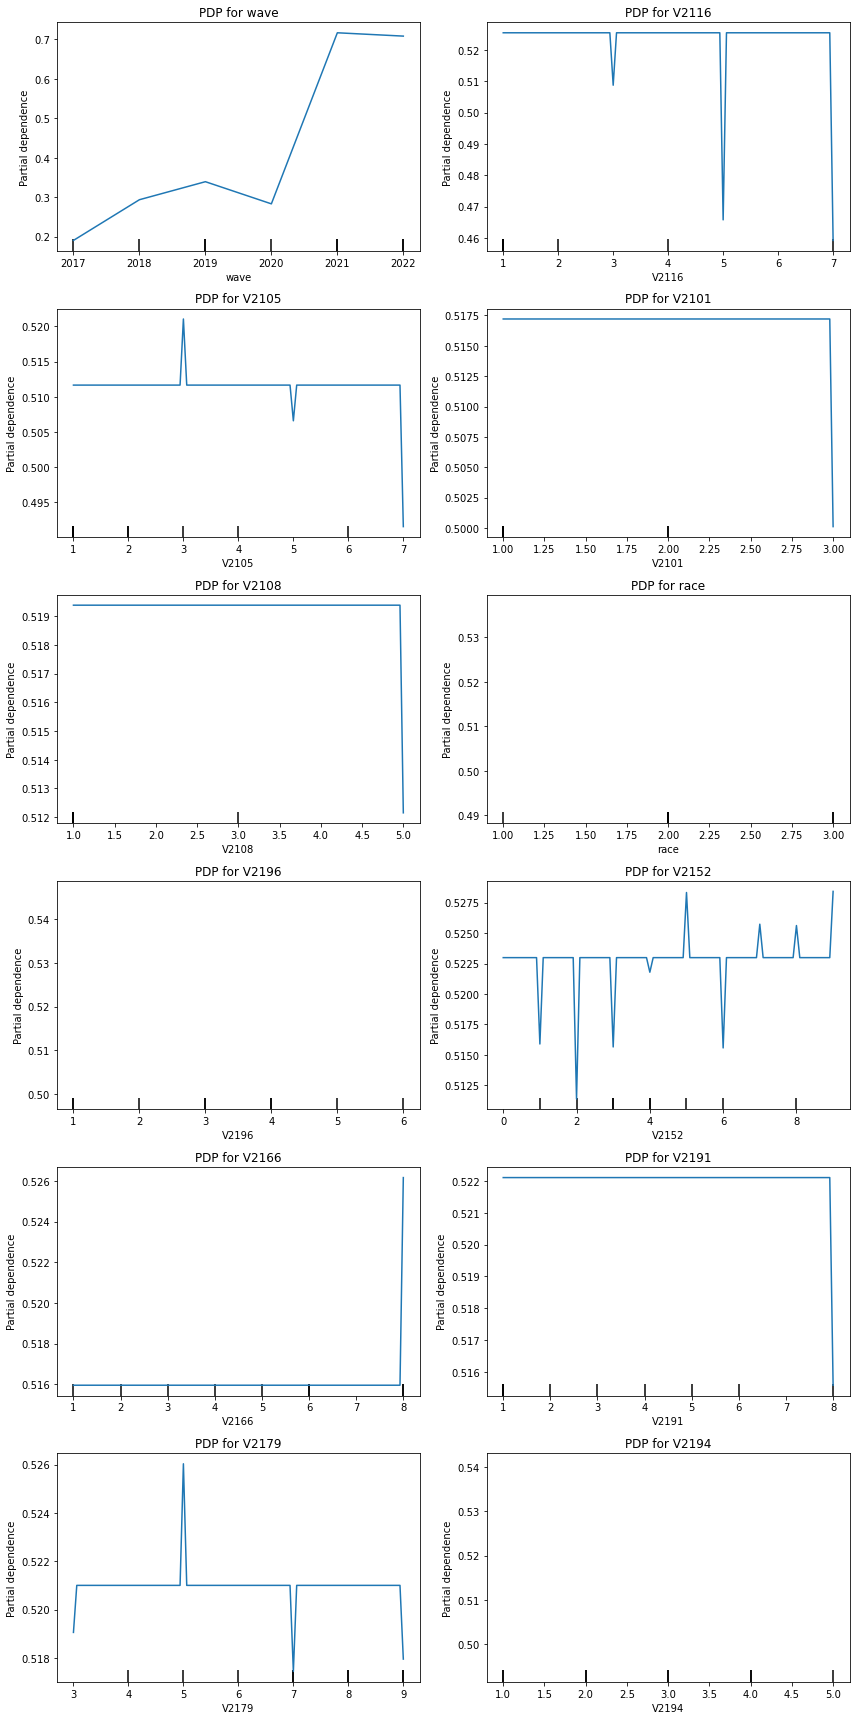

In [22]:
# 1) Sort by descending importance and take top 10.
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
top_10_features = feature_importance_df['Feature'].head(13).tolist()

# 2) Exclude features that start with "missing_" 
#    or that don’t actually exist in X_train_with_indicators.
filtered_features = [
    f for f in top_10_features 
    if not f.startswith('missing_') and f in X_train_with_indicators.columns
]

print("Top 10 original features:", top_10_features)
print("Filtered features (excluding 'missing_'): ", filtered_features)

# 3) Plot PDPs for the filtered features
n_features = len(filtered_features)
n_rows = (n_features + 1) // 2  # so we can arrange them in a grid
n_cols = 2
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 4*n_rows), squeeze=False)
axes = axes.flatten()

for i, feat in enumerate(filtered_features):
    ax = axes[i]
    PartialDependenceDisplay.from_estimator(
        estimator=loaded_gbt,
        X=X_train_with_indicators,
        features=[feat],
        feature_names=X_train_with_indicators.columns,
        kind='average',  # or 'both' if you want ICE lines
        ax=ax
    )
    ax.set_title(f"PDP for {feat}")

# If there are unused subplots, hide them
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [23]:
# Extract the GradientBoostingClassifier
gbt_model = loaded_gbt.named_steps['classifier']
# Get preprocessed features
X_preprocessed = loaded_gbt.named_steps['preprocessor'].transform(X_test_with_indicators)

In [24]:
# Now create the SHAP explainer
explainer = shap.TreeExplainer(gbt_model)
# Calculate SHAP values
shap_values = explainer.shap_values(X_preprocessed)

In [25]:
# Get feature names after preprocessing
feature_names = loaded_gbt.named_steps['preprocessor'].get_feature_names_out()

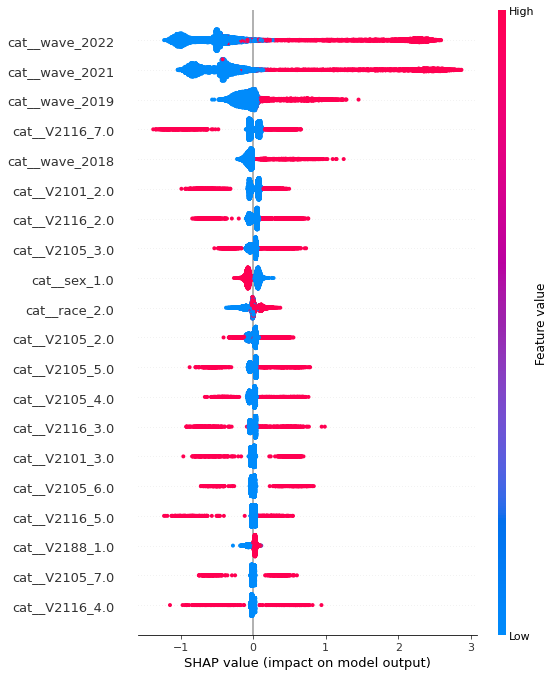

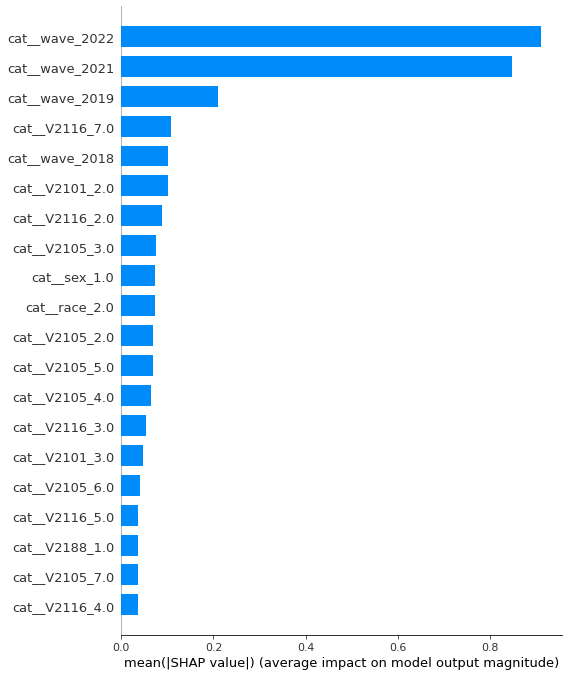

In [26]:
# Create visualizations
# Summary plot
shap.summary_plot(shap_values, X_preprocessed, feature_names=feature_names)
# Bar plot of feature importance
shap.summary_plot(shap_values, X_preprocessed, feature_names=feature_names, plot_type='bar')

In [37]:
# 1. Aggregate SHAP values by base feature
feature_importances = {}
for i, col in enumerate(feature_names):
    base_feature = '_'.join(col.split('_')[:-1])  # Extract base feature name
    if base_feature not in feature_importances:
        feature_importances[base_feature] = []
    feature_importances[base_feature].extend(np.abs(shap_values[:, i]))

# 2. Calculate mean absolute SHAP value for each base feature
aggregated_importances = {
    feature: np.mean(values) for feature, values in feature_importances.items()
}

# 3. Sort features by importance
sorted_importances = sorted(
    aggregated_importances.items(), key=lambda item: item[1], reverse=True
)

# 4. Create a DataFrame for plotting
importance_df = pd.DataFrame(sorted_importances, columns=['Feature', 'Importance'])

# Filter to show only the top 20 features
top_20_importance_df = importance_df.head(20)

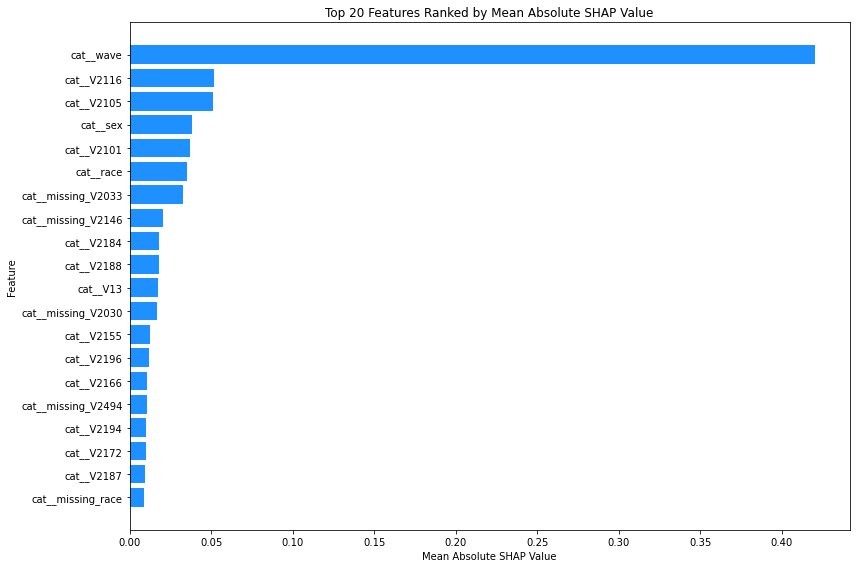

In [40]:
# 5. Create the bar plot
plt.figure(figsize=(12, 8))  # Adjust size as needed
plt.barh(top_20_importance_df['Feature'], top_20_importance_df['Importance'], color='dodgerblue')
plt.xlabel('Mean Absolute SHAP Value')
plt.ylabel('Feature')
plt.title('Top 20 Features Ranked by Mean Absolute SHAP Value')
plt.gca().invert_yaxis()  # Most important feature on top
plt.tight_layout()
plt.show()

In [29]:
# For individual predictions (e.g., first sample)
shap.initjs()  # Initialize JavaScript visualization
single_sample_idx = 0
shap.force_plot(explainer.expected_value[1] if isinstance(shap_values, list) else explainer.expected_value,
                shap_values[single_sample_idx] if isinstance(shap_values, list) else shap_values[single_sample_idx,:],
                X_preprocessed[single_sample_idx],
                feature_names=feature_names)

In [43]:
# For individual predictions (e.g., first sample)
single_sample_idx = 0
single_sample_shap_values = shap_values[single_sample_idx] if isinstance(shap_values, list) else shap_values[single_sample_idx, :]

# Aggregate SHAP values by base feature for the single sample
feature_importances = {}
for i, feature_name in enumerate(feature_names):
    base_feature = '_'.join(feature_name.split('_')[:-1])  # Extract base feature name
    shap_value = single_sample_shap_values[i]
    feature_importances[base_feature] = feature_importances.get(base_feature, 0) + abs(shap_value)

# Sort features by importance
sorted_importances = sorted(feature_importances.items(), key=lambda item: item[1], reverse=True)

# Print the ranked feature importance for the single prediction
print(f"Overall Feature Importance for Sample {single_sample_idx}:")
for feature, importance in sorted_importances:
    print(f"{feature}: {importance:.4f}")

Overall Feature Importance for Sample 0:
cat__wave: 2.4482
cat__V2116: 0.2640
cat__V2105: 0.1783
cat__V2101: 0.1063
cat__sex: 0.0822
cat__V2152: 0.0715
cat__V2201: 0.0631
cat__V2173: 0.0628
cat__V2166: 0.0569
cat__V2184: 0.0526
cat__V2191: 0.0493
cat__V2196: 0.0492
cat__V2188: 0.0410
cat__V2164: 0.0357
cat__V2194: 0.0328
cat__missing_V2030: 0.0322
cat__V2908: 0.0321
cat__missing_V2033: 0.0302
cat__V2177: 0.0292
cat__V2155: 0.0279
cat__V2187: 0.0275
cat__V2193: 0.0263
cat__V2163: 0.0254
cat__V2179: 0.0249
cat__V2033: 0.0241
cat__V49: 0.0240
cat__V2108: 0.0234
cat__V13: 0.0213
cat__V2178: 0.0212
cat__V2172: 0.0204
cat__V2157: 0.0189
cat__V2183: 0.0176
cat__V2119: 0.0175
cat__V2494: 0.0172
cat__RESPONDENT_AGE: 0.0152
cat__V2146: 0.0148
cat__V2189: 0.0144
cat__V2169: 0.0133
cat__V2195: 0.0129
cat__missing_V2146: 0.0123
cat__V2181: 0.0108
cat__V2180: 0.0107
cat__missing_V2494: 0.0097
cat__V2197: 0.0087
cat__V2176: 0.0082
cat__missing_V2907: 0.0072
cat__race: 0.0070
cat__V2182: 0.0062
cat__V

In [31]:
# SHAP feature interaction

# Calculate SHAP interaction values
shap_interaction_values = explainer.shap_interaction_values(X_preprocessed)

In [44]:
# Interaction of the top 2 features
top_features_indices = np.argsort(np.abs(shap_values).mean(0))[-2:]  # Get indices of top 2 features
feature1_idx = top_features_indices[0]
feature2_idx = top_features_indices[1]
feature1_name = feature_names[feature1_idx]
feature2_name = feature_names[feature2_idx]

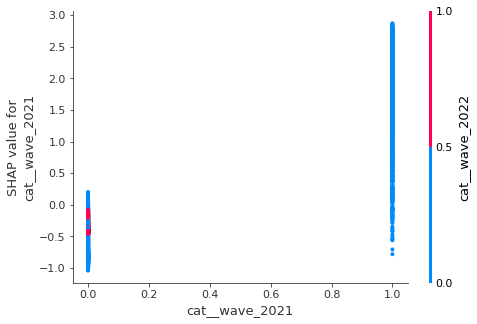

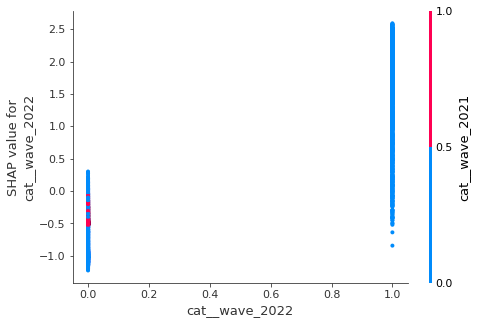

In [45]:
# Visualize the interaction between the top two features
shap.dependence_plot(
    feature1_idx,
    shap_values,
    X_preprocessed,
    feature_names=feature_names,
    interaction_index=feature2_idx,
)

shap.dependence_plot(
    feature2_idx,
    shap_values,
    X_preprocessed,
    feature_names=feature_names,
    interaction_index=feature1_idx,
)

In [50]:
# 1. Group feature indices by base feature
base_feature_indices = {}
for i, feature_name in enumerate(feature_names):
    base_feature = '_'.join(feature_name.split('_')[:-1])
    if base_feature not in base_feature_indices:
        base_feature_indices[base_feature] = []
    base_feature_indices[base_feature].append(i)

# 2. Calculate overall interaction importance for each pair of base features
base_feature_interaction_importance = {}
base_feature_names = list(base_feature_indices.keys())

for bf1_idx, base_feature1 in enumerate(base_feature_names):
    for bf2_idx in range(bf1_idx, len(base_feature_names)):
        base_feature2 = base_feature_names[bf2_idx]

        interaction_sum = 0
        for i in base_feature_indices[base_feature1]:
            for j in base_feature_indices[base_feature2]:
                # Handle multi-class case if shap_interaction_values is a list
                if isinstance(shap_interaction_values, list):
                    interaction_sum += shap_interaction_values[0][0, i, j]  # Assuming binary or focusing on one class
                else:
                    interaction_sum += shap_interaction_values[0, i, j]

        base_feature_interaction_importance[(base_feature1, base_feature2)] = abs(interaction_sum)

# 3. Sort base feature interactions by importance
sorted_base_feature_interactions = sorted(
    base_feature_interaction_importance.items(), key=lambda item: item[1], reverse=True
)

# 4. Print the top 50 ranked base feature interactions
print("Top 50 Overall Base Feature Interaction Importance:")
for (bf1, bf2), importance in sorted_base_feature_interactions[:50]:  # Limit to top 50
    print(f"Interaction between {bf1} and {bf2}: {importance:.4f}")


Top 50 Overall Base Feature Interaction Importance:
Interaction between cat__wave and cat__wave: 1.1340
Interaction between cat__V2116 and cat__wave: 0.2434
Interaction between cat__V2105 and cat__wave: 0.2304
Interaction between cat__V2101 and cat__wave: 0.1138
Interaction between cat__V2201 and cat__wave: 0.1103
Interaction between cat__V2194 and cat__V2194: 0.0725
Interaction between cat__sex and cat__sex: 0.0689
Interaction between cat__V2201 and cat__V2201: 0.0613
Interaction between cat__V2105 and cat__V2105: 0.0595
Interaction between cat__V2166 and cat__V2166: 0.0541
Interaction between cat__race and cat__race: 0.0473
Interaction between cat__wave and cat__race: 0.0461
Interaction between cat__missing_V2033 and cat__missing_V2033: 0.0460
Interaction between cat__V2033 and cat__V2033: 0.0365
Interaction between cat__V13 and cat__V13: 0.0357
Interaction between cat__V2169 and cat__V2169: 0.0356
Interaction between cat__V2152 and cat__V2152: 0.0310
Interaction between cat__V2108 a

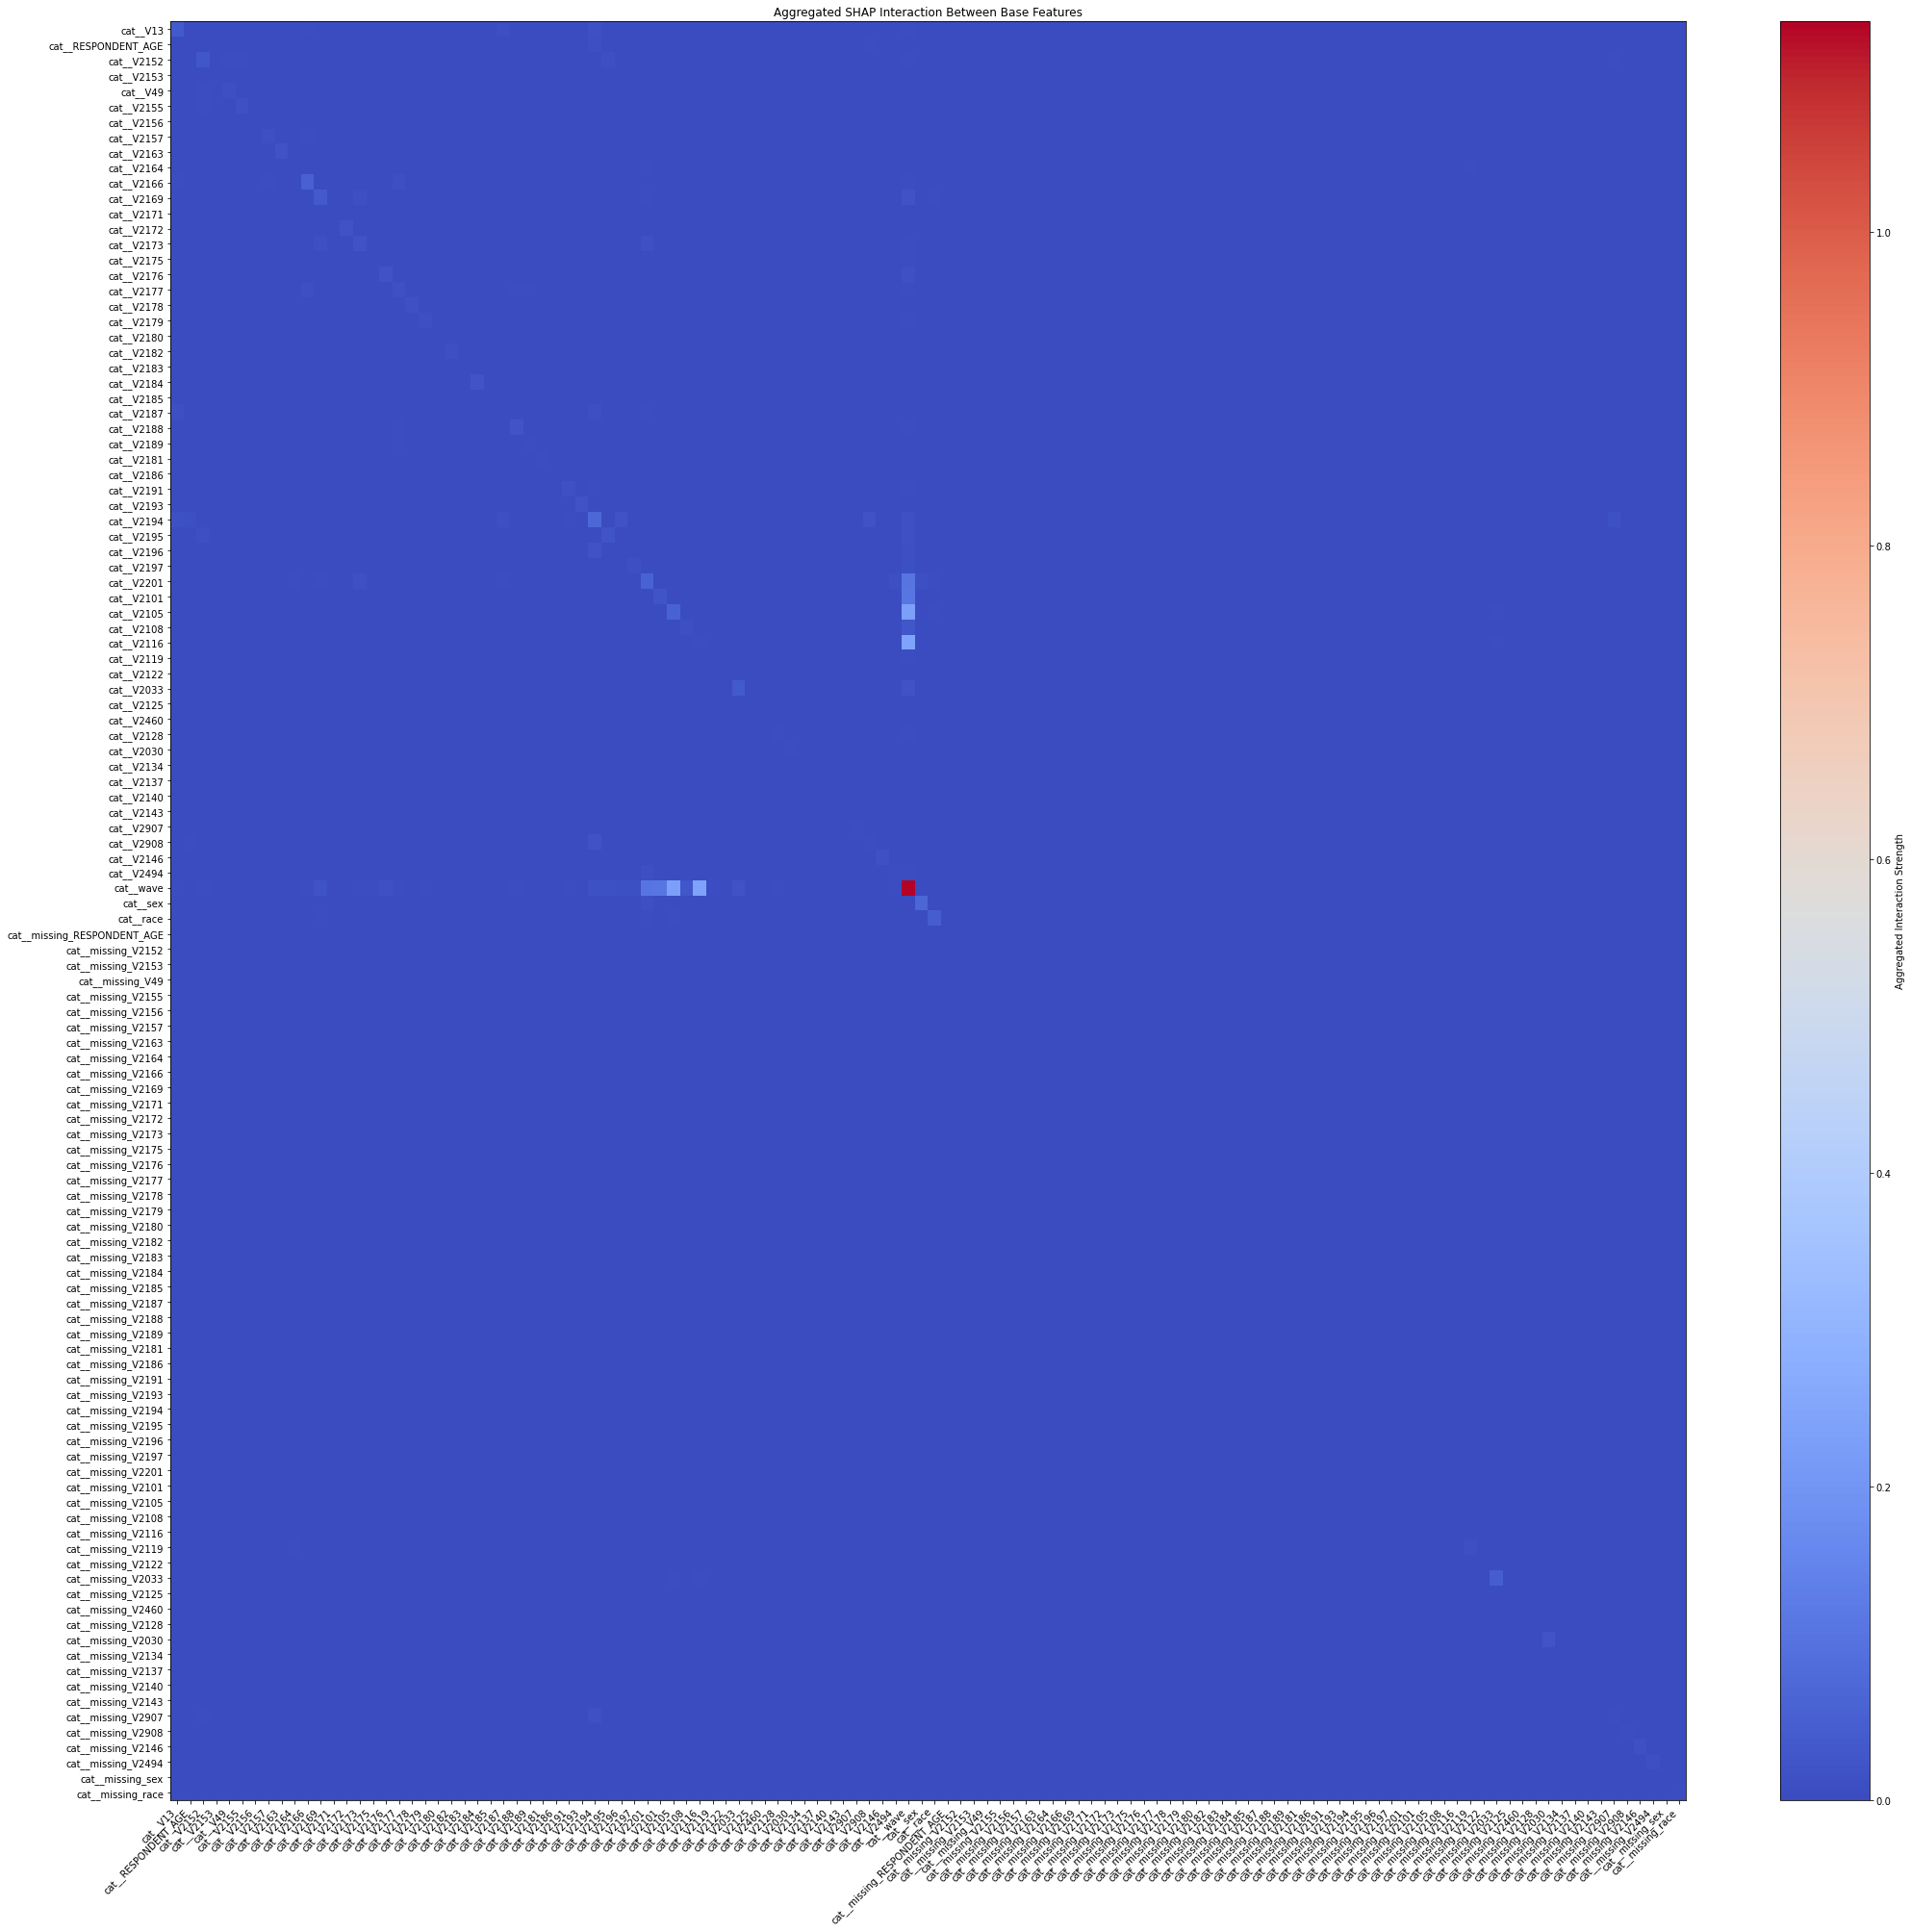

In [35]:
# 3. Create a matrix for the heatmap
num_base_features = len(base_feature_names)
interaction_matrix = np.zeros((num_base_features, num_base_features))

for i, bf1 in enumerate(base_feature_names):
    for j, bf2 in enumerate(base_feature_names):
        # Use the sorted tuple for lookup
        key = tuple(sorted((bf1, bf2)))
        if key in base_feature_interaction_importance:
            interaction_matrix[i, j] = base_feature_interaction_importance[key]
        #else:
        #    print(f"Warning: Interaction not found for {bf1}, {bf2}") # Optional debugging

# 4. Visualize the aggregated interaction using a heatmap
plt.figure(figsize=(30, 28))
plt.imshow(interaction_matrix, cmap='coolwarm', aspect='auto')
plt.colorbar(label='Aggregated Interaction Strength')
plt.xticks(range(num_base_features), base_feature_names, rotation=45, ha="right")
plt.yticks(range(num_base_features), base_feature_names)
plt.title('Aggregated SHAP Interaction Between Base Features')
plt.tight_layout()
plt.show()

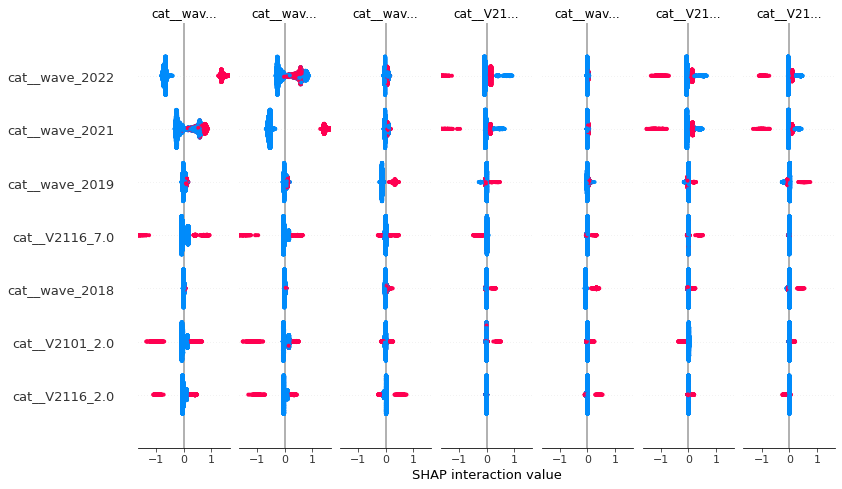

In [36]:
# Interaction Summary Plot (for overall interaction strengths)
shap.summary_plot(shap_interaction_values, X_preprocessed, feature_names=feature_names)

## Histogram-based Gradient Boost Classifier

In [ ]:
# ================
# 4. MODEL TRAINING - HISTOGRAM GRADIENT BOOSTING
# ================

# Configure environment for optimal parallelism
import os
os.environ["OMP_NUM_THREADS"] = "1"  # Controls hist gradient boosting threads
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline

# Define model path
HIST_GB_MODEL_PATH = os.path.expanduser('~/work/vaping_project_data/best_hist_gbt_model.joblib')

# Initialize classifier with early stopping
hgbc = HistGradientBoostingClassifier(
    early_stopping=True,
    random_state=RANDOM_STATE,
    verbose=VERBOSE,
    scoring=SCORING_METRIC,
    validation_fraction=0.1,
    max_iter=500,  # Will stop early if no improvement
    categorical_features=X_train_with_indicators.dtypes == 'category'  # Auto-detect categoricals
)

# Create minimal pipeline (no preprocessing needed)
# Build pipeline
hgbc_pipeline = Pipeline([
    ('preprocessor', preprocessor), 
    ('classifier', HistGradientBoostingClassifier(random_state=RANDOM_STATE))
])

# Optimized parameter grid for 24-core/100GB RAM
param_grid = {
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],  # Wider range including very low rates
    'classifier__max_depth': [6, 12, 18],                 # Deeper trees with more variation
    'classifier__min_samples_leaf': [20, 50, 100],        # More granular leaf sizes
    'classifier__l2_regularization': [0.0, 0.1, 0.5, 1.0],# Stronger regularization options
    'classifier__max_bins': [255],                        # Keep max bins for accuracy
    'classifier__max_leaf_nodes': [64, 128, 256],         # Control tree complexity
    'classifier__max_iter': [2000],                       # Let early stopping handle actual iterations
}

# Optimized grid search configuration
best_hist_gbc = perform_grid_search(
    pipeline=hgbc_pipeline,
    param_grid=param_grid,
    X_train=X_train_with_indicators,
    y_train=y_train,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),  # More reliable 5-fold CV
    scoring=SCORING_METRIC,
    n_jobs=24,  # Full parallelization
    verbose=2
)

2025-01-21 18:31:39,967 - INFO - === Histogram Gradient Boosting Evaluation ===
2025-01-21 18:31:39,974 - INFO - Confusion Matrix:
[[2767  617]
 [ 637 3029]]
2025-01-21 18:31:39,989 - INFO - 
Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.82      0.82      3384
         1.0       0.83      0.83      0.83      3666

    accuracy                           0.82      7050
   macro avg       0.82      0.82      0.82      7050
weighted avg       0.82      0.82      0.82      7050

2025-01-21 18:31:39,994 - INFO - ROC AUC: 0.9081


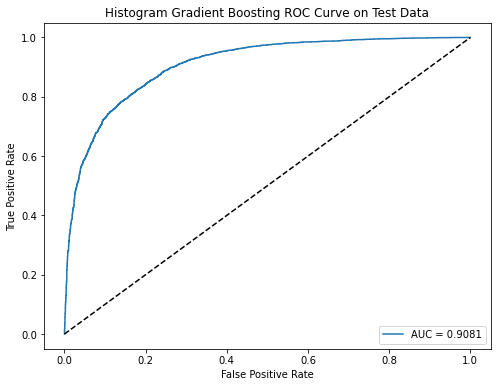

2025-01-21 18:31:40,349 - INFO - Histogram Gradient Boosting saved to '/storage/home/szn5432/work/vaping_project_data/best_hist_gbt_model.joblib'.


In [83]:
# Evaluate and save best model
trained_model = train_evaluate_model(
    best_hist_gbc,
    X_train=X_train_with_indicators,
    y_train=y_train,
    X_test=X_test_with_indicators,
    y_test=y_test,
    model_name="Histogram Gradient Boosting",
    save_path=HIST_GB_MODEL_PATH
)

In [107]:
# Reload model
try:
    loaded_hgbt = joblib.load(HIST_GB_MODEL_PATH)
    logging.info("Model reload successful!")
except Exception as e:
    logging.error(f"Model reload failed: {str(e)}")

2025-01-21 20:45:24,703 - INFO - Model reload successful!


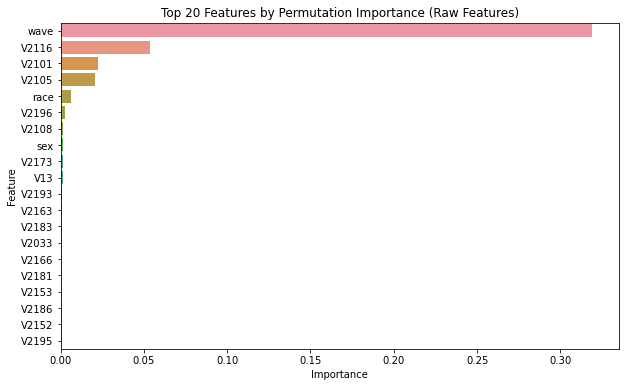

In [145]:
from sklearn.inspection import permutation_importance

# Calculate permutation importance on RAW DATA (let pipeline handle preprocessing)
result = permutation_importance(
    best_hist_gbc,  # This is your full pipeline
    X_test_with_indicators,  # Raw data with missing indicators
    y_test,
    n_repeats=5,
    random_state=RANDOM_STATE,
    n_jobs=CPU_COUNT
)

# Get feature names from the raw data (including missing indicators)
feature_names = X_test_with_indicators.columns.tolist()

# Create importance DataFrame
perm_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': result.importances_mean
}).sort_values('Importance', ascending=False)

# Plot top 20
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=perm_importance.head(20))
plt.title("Top 20 Features by Permutation Importance (Raw Features)")
plt.show()

In [147]:
# Create a table for top 20 feature importances
top_20_features = perm_importance.head(20)

# Display the table
print("Top 20 Feature Importances:")
display(top_20_features.style.background_gradient(cmap='Blues', subset=['Importance']))

Top 20 Feature Importances:


,Feature,Importance,BaseFeature
56,wave,0.318979,wave
40,V2116,0.053504,V2116
37,V2101,0.022411,V2101
38,V2105,0.020454,V2105
58,race,0.006156,race
34,V2196,0.002440,V2196
39,V2108,0.001730,V2108
57,sex,0.001617,sex
14,V2173,0.001532,V2173
0,V13,0.001305,V13


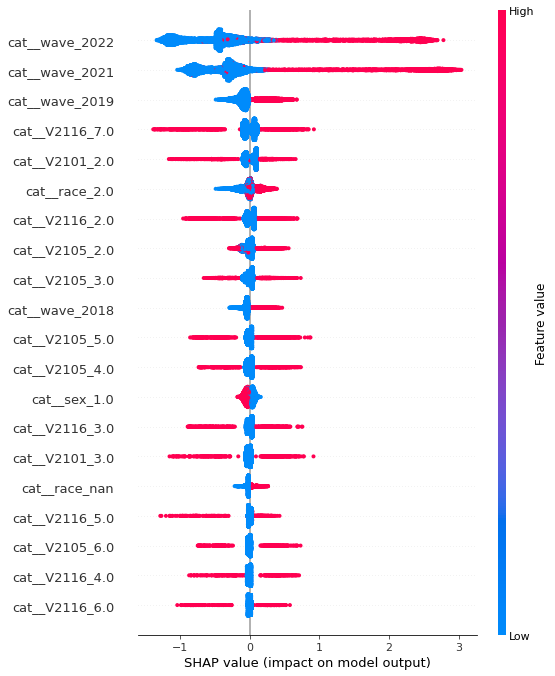

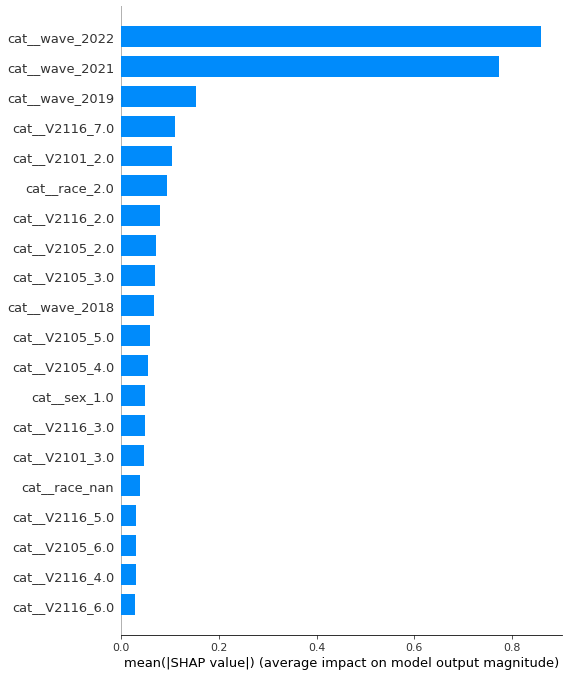

In [88]:
# Extract the GradientBoostingClassifier 
hgbt_model = loaded_hgbt.named_steps['classifier'] 

# Get preprocessed features 
X_preprocessed = loaded_hgbt.named_steps['preprocessor'].transform(X_test_with_indicators) 

# Now create the SHAP explainer 
explainer = shap.TreeExplainer(hgbt_model) 

# Calculate SHAP values 
shap_values = explainer.shap_values(X_preprocessed) 

# Get feature names after preprocessing 
feature_names = loaded_hgbt.named_steps['preprocessor'].get_feature_names_out() 

# Create visualizations 
# Summary plot 
shap.summary_plot(shap_values, X_preprocessed, feature_names=feature_names) 

# Bar plot of feature importance 
shap.summary_plot(shap_values, X_preprocessed, feature_names=feature_names, plot_type='bar')

Top 20 Aggregated SHAP Feature Importances:


,Feature,SHAP_Importance
0,V2137,1.429939
1,V2196,0.326269
2,V2194,0.245277
3,V2195,0.155698
4,V2193,0.151521
5,V2176,0.137626
6,V2163,0.129935
7,V2140,0.114753
8,V2197,0.109766
9,V2189,0.082001


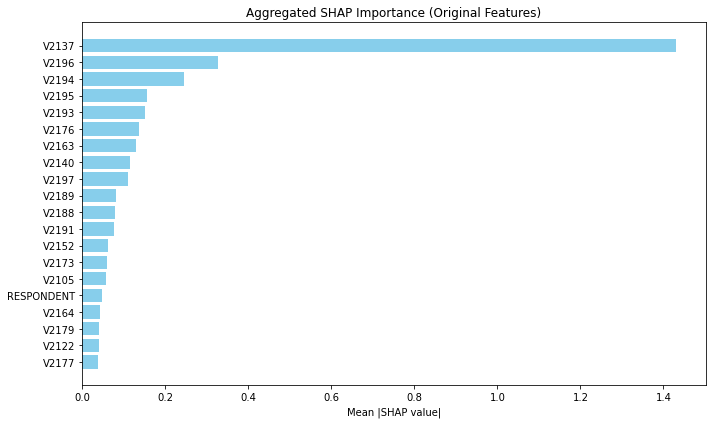

In [179]:
import numpy as np
import pandas as pd

# -------------------------------------------------------------------
# 1. Get feature names after preprocessing
# -------------------------------------------------------------------
feature_names = preprocessor.get_feature_names_out()

# -------------------------------------------------------------------
# 2. Separate original features from missing indicators
# -------------------------------------------------------------------
original_features = [feat for feat in feature_names if feat.startswith("cat__")]

# -------------------------------------------------------------------
# 3. Extract base feature names CORRECTLY
# -------------------------------------------------------------------
base_feature_names = []
for feat in original_features:
    # Split on double underscores first: "cat__V13_1" -> ["cat", "V13_1"]
    parts = feat.split("__", 1)
    if len(parts) > 1:
        # Split the remaining part on the first underscore: "V13_1" -> ["V13", "1"]
        base_feature = parts[1].split("_", 1)[0]
    else:
        base_feature = feat  # Fallback if splitting fails
    base_feature_names.append(base_feature)

# -------------------------------------------------------------------
# 4. Subset SHAP values for original features
# -------------------------------------------------------------------
original_feature_indices = [i for i, feat in enumerate(feature_names) if feat in original_features]
shap_values_original = shap_values[:, original_feature_indices]

# -------------------------------------------------------------------
# 5. Aggregate SHAP values
# -------------------------------------------------------------------
mean_shap = np.abs(shap_values_original).mean(axis=0)

aggregated_shap_df = (
    pd.DataFrame({"Feature": base_feature_names, "SHAP_Importance": mean_shap})
    .groupby("Feature")
    .sum()
    .sort_values("SHAP_Importance", ascending=False)
    .reset_index()
)

# -------------------------------------------------------------------
# 6. Display and plot results
# -------------------------------------------------------------------
print("Top 20 Aggregated SHAP Feature Importances:")
display(aggregated_shap_df.head(20))

plt.figure(figsize=(10, 6))
plt.barh(
    aggregated_shap_df.head(20)["Feature"][::-1],
    aggregated_shap_df.head(20)["SHAP_Importance"][::-1],
    color="skyblue",
)
plt.xlabel("Mean |SHAP value|")
plt.title("Aggregated SHAP Importance (Original Features)")
plt.tight_layout()
plt.show()

# XGBOOST

In [ ]:
# pip install optuna

In [236]:
# Create an XGBoost Classifier
model = xgb.XGBClassifier(
    objective='binary:logistic',  # Binary classification
    eval_metric='logloss',        # Log-loss evaluation metric
    random_state=42,
    use_label_encoder=False,
    enable_categorical=True# To avoid deprecation warning
)

# Fit the model
model.fit(X_train_with_indicators, y_train)


/storage/home/szn5432/.local/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:15:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [228]:
# Train and evaluate the model
trained_model = train_evaluate_model(
    pipeline, 
    X_train_with_indicators, 
    y_train, 
    X_test_with_indicators, 
    y_test,
    model_name="XGBoost Classifier"
)

AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [ ]:
# Test on test set
if y_test is not None:
    # Make predictions
    y_pred = final_pipeline.predict(X_test)
    y_pred_proba = final_pipeline.predict_proba(X_test)[:, 1]  # Probability of class '1'

    # Evaluation Metrics
    print("=== Test Data Evaluation ===")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
    
    # ROC Curve
    fpr, tpr, thresholds = roc_curve(
        y_test, 
        y_pred_proba, 
        pos_label=final_pipeline.named_steps['classifier'].classes_[1]
    )
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_pred_proba):.4f}')
    plt.plot([0, 1], [0, 1], 'k--')  # Add diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve on Test Data')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()
else:
    # If test_data does not contain true labels, save predictions
    y_pred = final_pipeline.predict(X_test)
    y_pred_proba = final_pipeline.predict_proba(X_test)[:, 1]  # Probability of class '1'
    
    # Create a DataFrame to save predictions
    test_predictions_df = X_test.copy()
    test_predictions_df['predicted_class'] = y_pred
    test_predictions_df['predicted_proba'] = y_pred_proba
    
    # Save the predictions to a CSV file
    test_predictions_df.to_csv('test_predictions.csv', index=False)
    print("Predictions saved to 'test_predictions.csv'.")

In [ ]:
# Ensure the pipeline is already fitted
if not hasattr(final_pipeline, "fit"):
    final_pipeline.fit(X_train, y_train)

In [ ]:
from sklearn.inspection import permutation_importance

# Calculate permutation importance
perm_importance = permutation_importance(
    final_pipeline, X_test, y_test, 
    scoring='roc_auc', 
    n_repeats=10, 
    random_state=123, 
    n_jobs=-1
)

# Create a DataFrame for permutation importance
perm_importance_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': perm_importance.importances_mean,
    'Importance Std': perm_importance.importances_std
}).sort_values(by='Importance', ascending=False)

# Display Top 20 Permutation Importance Features
print("Top 20 Features by Permutation Importance:")
print(perm_importance_df.head(20))

In [ ]:
plt.figure(figsize=(12, 8))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=perm_importance_df.head(20)
)
plt.title('Top 20 Features by Permutation Importance')
plt.xlabel('Importance (Mean Decrease in ROC AUC)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## CatBoost

In [ ]:
# pip install catboost

In [222]:
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [223]:
# Indices of categorical columns in the dataset
cat_features_indices = [X_train_with_indicators.columns.get_loc(col) for col in categorical_cols]
cat_features_indices

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58]

In [224]:
# Define numerical and categorical columns
numerical_cols = X_train_with_indicators.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_train_with_indicators.select_dtypes(include=['object', 'category']).columns.tolist()

# Preprocessing: Scale numerical columns (categorical columns are handled natively by CatBoost)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols)
    ],
    remainder='passthrough'  # Keep categorical columns in their original form
)

# Define CatBoost pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Preprocess numerical columns only
    ('classifier', CatBoostClassifier(
        cat_features=cat_features_indices,  # Specify categorical features
        silent=True,  # Suppress verbosity
        random_seed=123  # For reproducibility
    ))
])

In [225]:
# Define hyperparameter grid
param_grid = {
    'classifier__iterations': [100, 300, 500],  # Number of boosting iterations
    'classifier__learning_rate': [0.01, 0.1, 0.2],  # Learning rate
    'classifier__depth': [4, 6, 8],  # Depth of trees
    'classifier__l2_leaf_reg': [1, 3, 5],  # L2 regularization
    'classifier__border_count': [32, 64, 128],  # Number of bins for numerical features
    'classifier__subsample': [0.8, 1.0]  # Subsample ratio of rows
}

In [226]:
# Define cross-validation strategy
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=123)

# Perform GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',  # Optimize for ROC AUC
    n_jobs=-1,  # Use all available CPUs
    verbose=1  # Verbose output
)

# Train the model
grid_search.fit(X_train_with_indicators, y_train)

# Display best parameters and cross-validation score
print("Best Parameters Found:")
print(grid_search.best_params_)
print(f"Best Cross-Validation ROC AUC: {grid_search.best_score_:.4f}")

Fitting 3 folds for each of 486 candidates, totalling 1458 fits


KeyboardInterrupt: 

In [ ]:
# Save the final model
final_pipeline = grid_search.best_estimator_
import joblib
joblib.dump(final_pipeline, "/storage/work/szn5432/vaping_project_data/catboost_optimized_model2.joblib")
print("Optimized model saved to 'catboost_optimized_model2.joblib'.")

In [ ]:
# Load the model (when needed)
file_path = os.path.expanduser('~/work/vaping_project_data/catboost_optimized_model2.joblib')
loaded_catboost = joblib.load(file_path)
print("Model loaded successfully.")

In [ ]:
# Test on test set
if y_test is not None:
    # Make predictions
    y_pred = loaded_catboost.predict(X_test_with_indicators)
    y_pred_proba = loaded_catboost.predict_proba(X_test_with_indicators)[:, 1]  # Probability of class '1'

    # Evaluation Metrics
    print("=== Test Data Evaluation ===")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

    # ROC Curve
    from sklearn.metrics import roc_curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_pred_proba):.4f}')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve on Test Data')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()
else:
    # Save predictions if `y_test` is not available
    y_pred = grid_search.predict(X_test_with_indicators)
    y_pred_proba = grid_search.predict_proba(X_test_with_indicators)[:, 1]
    test_predictions_df = X_test_with_indicators.copy()
    test_predictions_df['predicted_class'] = y_pred
    test_predictions_df['predicted_proba'] = y_pred_proba
    test_predictions_df.to_csv('catboost_test_predictions.csv', index=False)
    print("Predictions saved to 'catboost_test_predictions.csv'.")

In [ ]:
# Retrieve the best CatBoost model from the pipeline
best_catboost_model = loaded_catboost.named_steps['classifier']

# Get feature names (numerical + categorical)
all_features = numerical_cols + categorical_cols

# Extract feature importances
feature_importance_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': best_catboost_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Display Top 20 Important Features
print("Top 20 Features by Importance:")
print(feature_importance_df.head(20))

In [ ]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
plt.title('Top 20 Features by Importance (CatBoost)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [ ]:
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    params = {
        'classifier__iterations': trial.suggest_int('iterations', 100, 1000),
        'classifier__learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'classifier__depth': trial.suggest_int('depth', 4, 10),
        'classifier__l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 10),
        'classifier__border_count': trial.suggest_categorical('border_count', [32, 64, 128, 256]),
        'classifier__subsample': trial.suggest_float('subsample', 0.5, 1.0)
    }

    pipeline.set_params(**params)
    score = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best Parameters Found:")
print(study.best_params)
print(f"Best ROC AUC: {study.best_value:.4f}")


In [ ]:
import joblib
from sklearn.metrics import roc_auc_score

# Set the best parameters found by Optuna
best_params = study.best_params

# Assuming the study.best_params dictionary contains the correct names like:
# {'iterations': 500, 'learning_rate': 0.1, ...}

# Update the pipeline with the best parameters found by Optuna
pipeline.set_params(
    classifier__iterations=best_params['iterations'],
    classifier__learning_rate=best_params['learning_rate'],
    classifier__depth=best_params['depth'],
    classifier__l2_leaf_reg=best_params['l2_leaf_reg'],
    classifier__border_count=best_params['border_count'],
    classifier__subsample=best_params['subsample']
)

# Train the final model on the entire training data
pipeline.fit(X_train, y_train)

# Step 2: Save the model using joblib
import joblib
joblib.dump(pipeline, 'catboost_model.pkl')
print("Model saved successfully!")

In [ ]:
# Test on Test Data
if y_test is not None:
    # Make predictions
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]  # Probability of class '1'

    # Evaluation Metrics
    print("=== Test Data Evaluation ===")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

    # ROC Curve
    from sklearn.metrics import roc_curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_pred_proba):.4f}')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve on Test Data')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()
else:
    # Save predictions if `y_test` is not available
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    test_predictions_df = X_test.copy()
    test_predictions_df['predicted_class'] = y_pred
    test_predictions_df['predicted_proba'] = y_pred_proba
    test_predictions_df.to_csv('catboost_test_predictions.csv', index=False)
    print("Predictions saved to 'catboost_test_predictions.csv'.")

In [ ]:
# Get the top 30 features
top_30_features = feature_importance_df.head(30)['Feature'].tolist()

# Display the top 30 features
print("Top 30 Features by Importance:")
print(top_30_features)


In [ ]:
# Select the top 30 features from X_train and X_test
X_train_selected = X_train[top_30_features]
X_test_selected = X_test[top_30_features]

# Save X_train_selected to a pickle file
X_train_selected.to_pickle('X_train_selected.pkl')

# Save X_test_selected to a pickle file
X_test_selected.to_pickle('X_test_selected.pkl')


In [ ]:
import pandas as pd
# Load X_train_selected from the pickle file
X_train_selected = pd.read_pickle('X_train_selected.pkl')

# Load X_test_selected from the pickle file
X_test_selected = pd.read_pickle('X_test_selected.pkl')

# Check the first few rows of each DataFrame to verify the load
print(X_train_selected.head())
print(X_test_selected.head())

In [ ]:
X_train_selected.dtypes

In [ ]:
# Indices of categorical columns in the dataset
cat_features_indices_s = [X_train.columns.get_loc(col) for col in categorical_cols]
cat_features_indices_s

# Identify numerical columns
numerical_cols = X_train_selected.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [ ]:
# Preprocessing: Scale numerical columns (categorical columns are handled natively by CatBoost)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols)
    ],
    remainder='passthrough'  # Keep categorical columns in their original form
)

# Define CatBoost pipeline
pipeline1 = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Preprocess numerical columns only
    ('classifier', CatBoostClassifier(
        cat_features=cat_features_indices_s,  # Specify categorical features
        silent=True,  # Suppress verbosity
        random_seed=123  # For reproducibility
    ))
])

In [ ]:
# Define cross-validation strategy
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=123)

# Perform GridSearchCV
grid_search_s = GridSearchCV(
    estimator=pipeline1,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',  # Optimize for ROC AUC
    n_jobs=-1,  # Use all available CPUs
    verbose=1  # Verbose output
)

# Train the model
grid_search_s.fit(X_train_selected, y_train)



In [ ]:
# Display best parameters and cross-validation score
print("Best Parameters Found:")
print(grid_search_s.best_params_)
print(f"Best Cross-Validation ROC AUC: {grid_search_s.best_score_:.4f}")

In [ ]:
#Test on Test Data
if y_test is not None:
    # Make predictions
    y_pred = grid_search_s.predict(X_test)
    y_pred_proba = grid_search_s.predict_proba(X_test)[:, 1]  # Probability of class '1'

    # Evaluation Metrics
    print("=== Test Data Evaluation ===")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

    # ROC Curve
    from sklearn.metrics import roc_curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_pred_proba):.4f}')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve on Test Data')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()
else:
    # Save predictions if `y_test` is not available
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    test_predictions_df = X_test.copy()
    test_predictions_df['predicted_class'] = y_pred
    test_predictions_df['predicted_proba'] = y_pred_proba
    test_predictions_df.to_csv('catboost_test_predictions.csv', index=False)
    print("Predictions saved to 'catboost_test_predictions.csv'.")